# Code authored by Avik Chakraborty {-}
# Project Name : Image Classification {-}
# Project Description : Feature Extraction using DNN and classifing using ML algorithms. {-}
# Dataset taken from : [Click Here](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) {-}

In [ ]:
import numpy
import pandas

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

import os

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn
import matplotlib.pyplot as mplot

In [2]:
dataset = pandas.read_csv('Image Path Class.csv')
dataset.head()

,locations,labels
0,Rice Image Dataset/Training Set/Arborio/Arbori...,0
1,Rice Image Dataset/Training Set/Arborio/Arbori...,0
2,Rice Image Dataset/Training Set/Arborio/Arbori...,0
3,Rice Image Dataset/Training Set/Arborio/Arbori...,0
4,Rice Image Dataset/Training Set/Arborio/Arbori...,0


# Images from each class

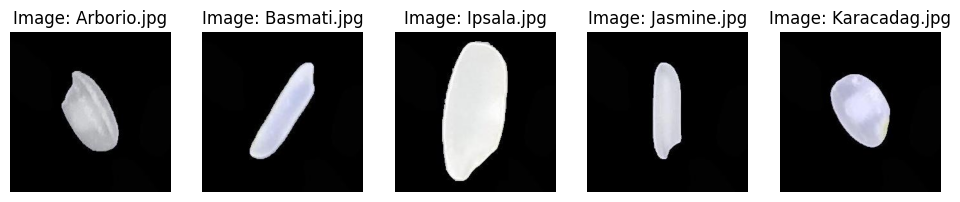

In [ ]:
images = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

figure, axes = mplot.subplots(1, 5, figsize = (12, 6))

i = 0

for image in images:
    imgPath = f'Rice Image to predict/{image}.jpg'
    img = load_img(imgPath) # Loading the image from directory

    # Showing the image as plot
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f'Image: {os.path.basename(imgPath)}')  # Display the image file name as title

    # Updating axes
    i += 1

mplot.show()

In [3]:
class_names = {0 : 'Arborio',
              1 : 'Basmati',
              2 : 'Ipsala',
              3 : 'Jasmine',
              4 : 'Karacadag'}

dataset['labels'] = dataset['labels'].map(class_names)

In [4]:
train_set, temp_df = train_test_split(
    dataset,
    test_size = 0.2,
    stratify = dataset['labels'],
    random_state = 42
)

validation_set, test_set = train_test_split(
    temp_df,
    test_size = 0.5,
    stratify = temp_df['labels'],
    random_state = 42)

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
)

val_test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [6]:
def preprocess_generator(dataframe, datagen, img_size = (224, 224), batch_size = 32):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col = 'locations',
        y_col = 'labels',
        target_size = img_size,
        class_mode = 'sparse',
        batch_size = batch_size,
        shuffle = False
    )

In [7]:
IMG_SIZE = (224, 224)
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32

In [8]:
train_gen = preprocess_generator(train_set, train_datagen, IMG_SIZE, TRAIN_BATCH_SIZE)
val_gen = preprocess_generator(validation_set, val_test_datagen, IMG_SIZE, VAL_BATCH_SIZE)
test_gen = preprocess_generator(test_set, val_test_datagen, IMG_SIZE, VAL_BATCH_SIZE)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [9]:
base_model = tensorflow.keras.applications.MobileNetV2(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
model = tensorflow.keras.Sequential([
    base_model,
    tensorflow.keras.layers.GlobalAveragePooling2D()
])

# Feature extraction

In [11]:
def extract_features(generator):
    features = []
    labels = []
    for _ in range(len(generator)):
        imgs, lbls = next(generator)
        feats = model.predict(imgs)
        features.append(feats)
        labels.append(lbls)
    features = numpy.vstack(features)
    labels = numpy.hstack(labels)
    return features, labels

In [12]:
xtrain, ytrain = extract_features(train_gen)
xval, yval = extract_features(val_gen)
xtest, ytest = extract_features(test_gen)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Dimension Reduction

In [13]:
pca = PCA(n_components = 50)

xtrain = pca.fit_transform(xtrain)
xval = pca.transform(xval)
xtest = pca.transform(xtest)

In [14]:
IMAGE_LABELS = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Model 1 : SVM

In [ ]:
svc = SVC()
svc.fit(xtrain, ytrain)
ypred = svc.predict(xval)

ypred = svc.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'SVC Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = svc.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'SVC Accuracy on Test Set: {test_acc*100:.2f} %')

SVC Accuracy on Validation Set: 95.47 %
SVC Accuracy on Test Set: 95.79 %


In [47]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      1500
         1.0       0.97      0.95      0.96      1500
         2.0       1.00      0.99      1.00      1500
         3.0       0.94      0.97      0.95      1500
         4.0       0.98      0.91      0.94      1500

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500



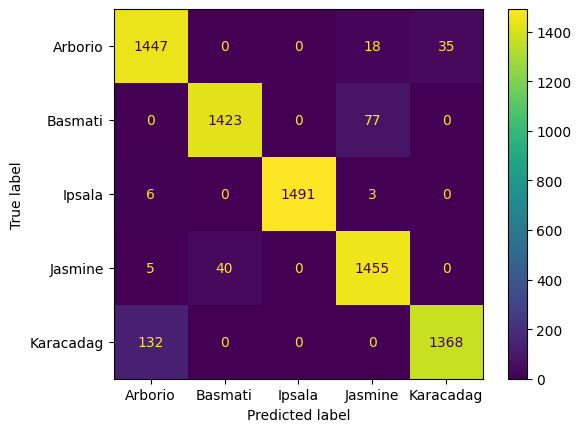

In [22]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 2: KNN

In [79]:
knn = KNeighborsClassifier() # 5 Neighbours
knn.fit(xtrain, ytrain)
ypred = knn.predict(xval)

ypred = knn.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'KNN Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = knn.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'KNN Accuracy on Test Set: {test_acc*100:.2f} %')

KNN Accuracy on Validation Set: 92.80 %
KNN Accuracy on Test Set: 92.93 %


In [50]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      1500
         1.0       0.90      0.95      0.92      1500
         2.0       1.00      0.99      1.00      1500
         3.0       0.92      0.89      0.91      1500
         4.0       0.91      0.93      0.92      1500

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500



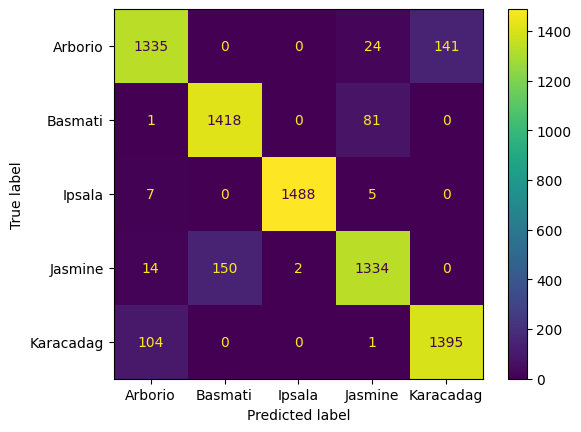

In [51]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 3 : Logistic Regresssion

In [96]:
lr = LogisticRegression(max_iter = 200)
lr.fit(xtrain, ytrain)
ypred = lr.predict(xval)

ypred = lr.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'Logistic Regression Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = lr.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'Logistic Regression Accuracy on Test Set: {test_acc*100:.2f} %')

Logistic Regression Accuracy on Validation Set: 93.67 %
Logistic Regression Accuracy on Test Set: 93.77 %


In [97]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1500
         1.0       0.93      0.93      0.93      1500
         2.0       1.00      0.99      1.00      1500
         3.0       0.91      0.92      0.92      1500
         4.0       0.97      0.89      0.93      1500

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500



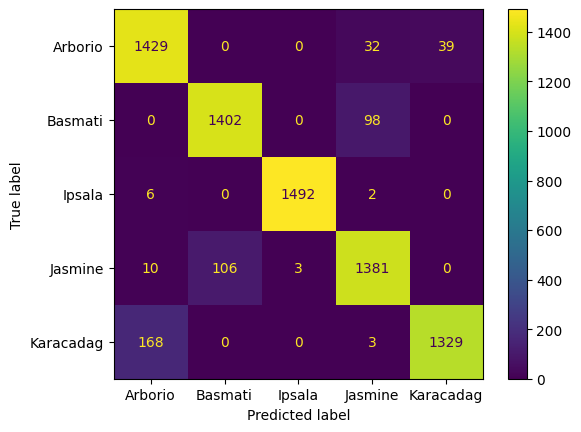

In [98]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 4 : Decision Tree

In [77]:
dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)
ypred = dt.predict(xval)

ypred = dt.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'Decision Tree Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = dt.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'Decision Tree Accuracy on Test Set: {test_acc*100:.2f} %')

Decision Tree Accuracy on Validation Set: 84.05 %
Decision Tree Accuracy on Test Set: 84.47 %


In [56]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      1500
         1.0       0.84      0.83      0.84      1500
         2.0       0.98      0.92      0.95      1500
         3.0       0.79      0.81      0.80      1500
         4.0       0.84      0.83      0.84      1500

    accuracy                           0.84      7500
   macro avg       0.84      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500



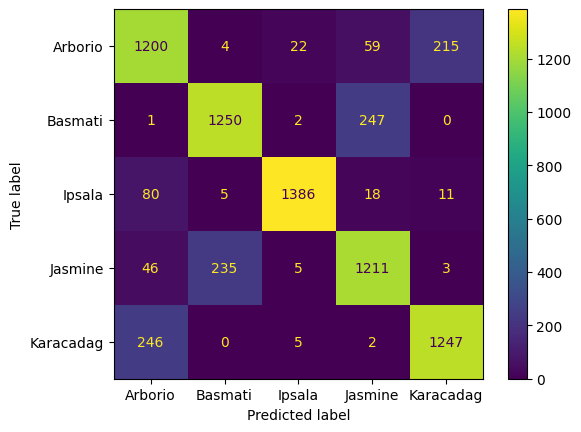

In [57]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 5 : Random Forest

In [76]:
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
ypred = rf.predict(xval)

ypred = rf.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'Random Forest Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = rf.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'Random Forest Accuracy on Test Set: {test_acc*100:.2f} %')

Random Forest Accuracy on Validation Set: 93.64 %
Random Forest Accuracy on Test Set: 94.05 %


In [59]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      1500
         1.0       0.93      0.93      0.93      1500
         2.0       1.00      0.99      0.99      1500
         3.0       0.91      0.92      0.91      1500
         4.0       0.93      0.94      0.93      1500

    accuracy                           0.94      7500
   macro avg       0.94      0.94      0.94      7500
weighted avg       0.94      0.94      0.94      7500



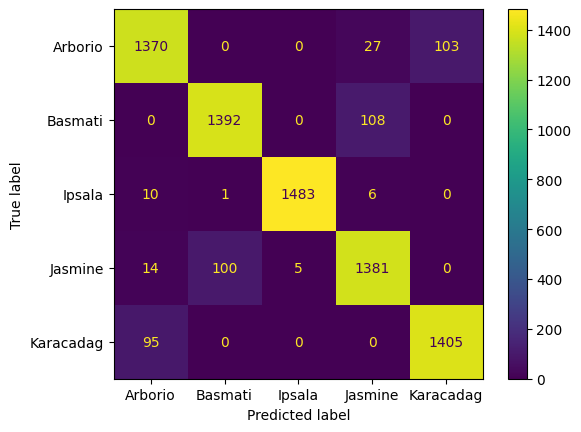

In [60]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 6 : XGBoost

In [75]:
xgb = XGBClassifier()
xgb.fit(xtrain, ytrain)
ypred = xgb.predict(xval)

ypred = xgb.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'XGBoost Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = xgb.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'XGBoost Accuracy on Test Set: {test_acc*100:.2f} %')

XGBoost Accuracy on Validation Set: 94.88 %
XGBoost Accuracy on Test Set: 94.69 %


In [63]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1500
         1.0       0.96      0.94      0.95      1500
         2.0       1.00      0.99      0.99      1500
         3.0       0.92      0.95      0.94      1500
         4.0       0.96      0.91      0.94      1500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



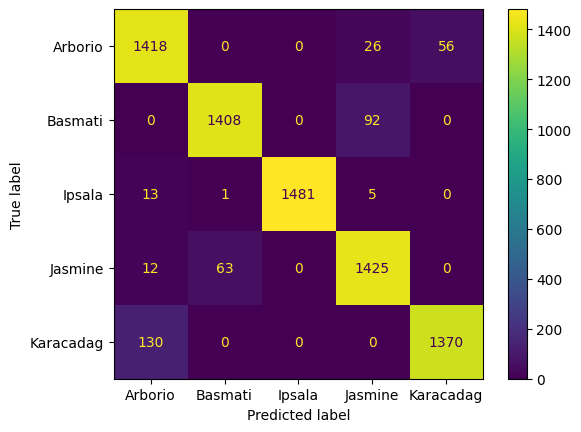

In [64]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 7 : LightGBM

In [74]:
lgbm = LGBMClassifier()
lgbm.fit(xtrain, ytrain)
ypred = lgbm.predict(xval)

ypred = lgbm.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'LightGBM Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = lgbm.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'LightGBM Accuracy on Test Set: {test_acc*100:.2f} %')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 50
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
LightGBM Accuracy on Validation Set: 94.61 %
LightGBM Accuracy on Test Set: 94.71 %


In [66]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1500
         1.0       0.95      0.94      0.95      1500
         2.0       1.00      0.99      0.99      1500
         3.0       0.92      0.95      0.94      1500
         4.0       0.96      0.91      0.94      1500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



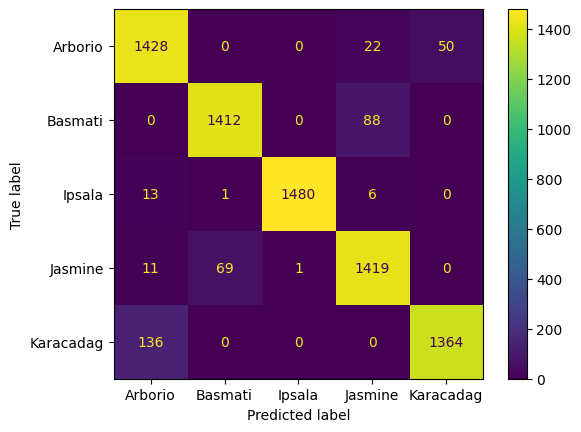

In [67]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Model 8 : CatBoost

In [71]:
cb = CatBoostClassifier(learning_rate = 0.1, iterations = 1000, depth = 6, verbose = 0)
cb.fit(xtrain, ytrain)
ypred = cb.predict(xval)

ypred = cb.predict(xval)
acc = accuracy_score(yval, ypred)
print(f'Catboost Accuracy on Validation Set: {acc*100:.2f} %')

ytest_pred = cb.predict(xtest)
test_acc = accuracy_score(ytest, ytest_pred)
print(f'Catboost Accuracy on Test Set: {test_acc*100:.2f} %')

Catboost Accuracy on Validation Set: 94.97 %
Catboost Accuracy on Test Set: 95.17 %


In [72]:
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      1500
         1.0       0.96      0.95      0.96      1500
         2.0       1.00      0.99      1.00      1500
         3.0       0.93      0.96      0.95      1500
         4.0       0.97      0.90      0.93      1500

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500



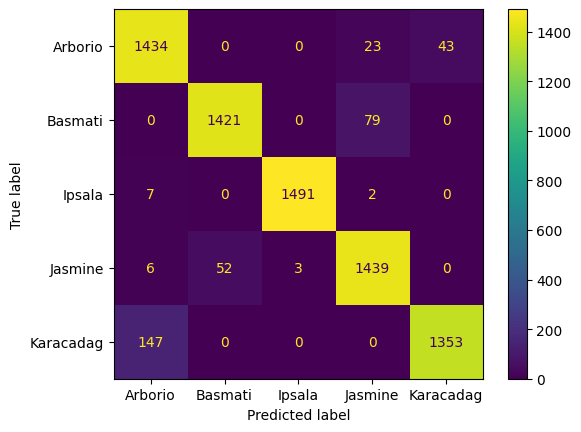

In [73]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(ytest, ytest_pred),
    display_labels = IMAGE_LABELS
).plot()

# Visualization
## Accuracy of Models

In [99]:
accuracy_val = [95.47, 92.80, 93.67, 84.05, 93.64, 94.88, 94.61, 94.97]
accuracy_test = [95.79, 92.93, 93.77, 84.47, 94.05, 94.69, 94.71, 95.17]
model_names = ['SVM', 'KNN', 'LR', 'DT', 'RF', 'XGB', 'LGBM', 'CB']

In [100]:
vis_data = {
    'Models' : model_names * 2,
    'Groups' : ['Validation'] * len(model_names) + ['Testing'] * len(model_names),
    'Accuracy' : accuracy_val + accuracy_test
}

temp_df = pandas.DataFrame(vis_data)

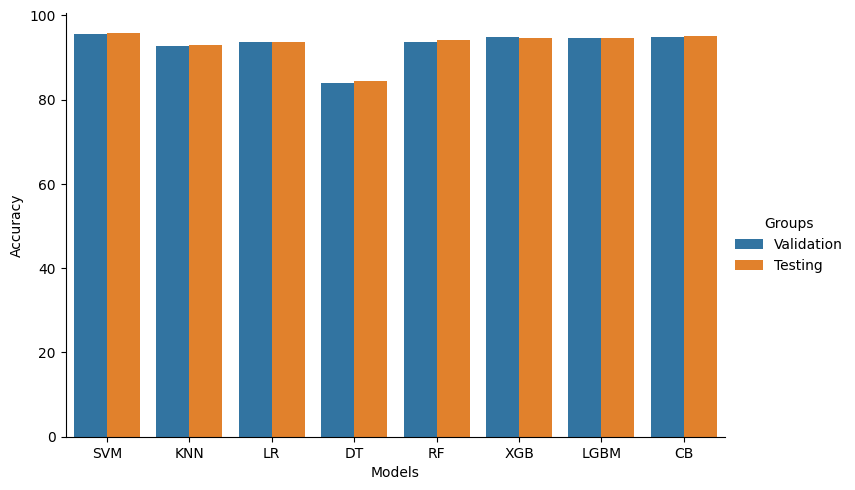

In [101]:
seaborn.catplot(
    data = temp_df,
    x = 'Models',
    y = 'Accuracy',
    hue = 'Groups',
    kind = 'bar',
    aspect = 1.5
)

## Dimension Reduction Plots after PCA

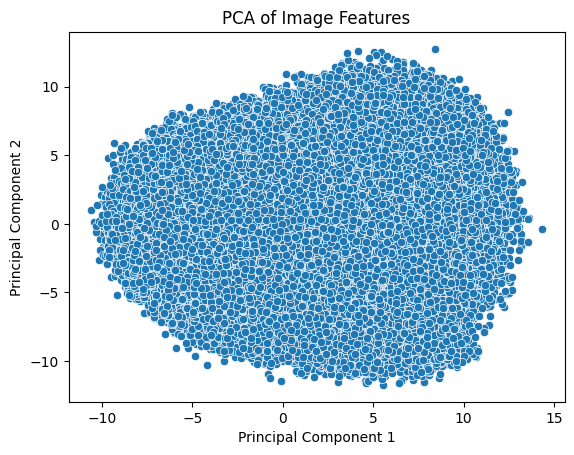

In [106]:
seaborn.scatterplot(x = xtrain[:, 0], y = xtrain[:, 1])
mplot.title('PCA of Image Features')
mplot.xlabel('Principal Component 1')
mplot.ylabel('Principal Component 2')
mplot.show()

In [ ]:
from sklearn.cluster import KMeans

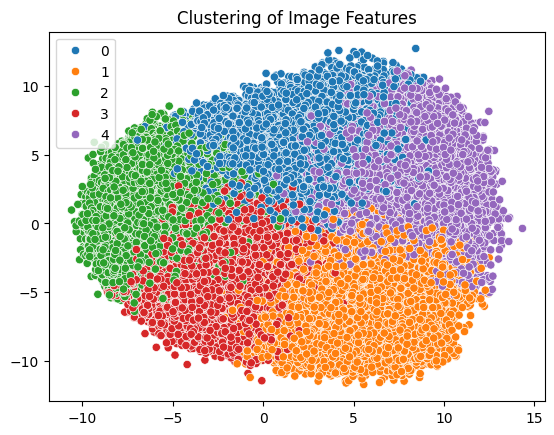

In [107]:
# Appling K-Means
kmeans = KMeans(n_clusters = 5, random_state = 42)
l = kmeans.fit_predict(xtrain)

# Visualizing clusters in 2D space
reduced_features = pca.fit_transform(xtrain)
seaborn.scatterplot(x = reduced_features[:, 0], y = reduced_features[:, 1], hue = l, palette = 'tab10')
mplot.title('Clustering of Image Features')
mplot.show()

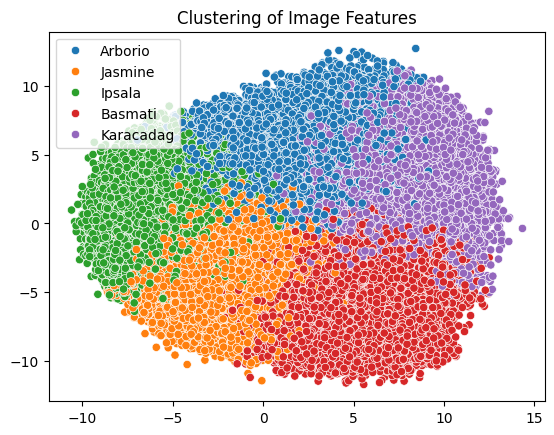

In [115]:
# Appling K-Means
kmeans1 = KMeans(n_clusters = 5, random_state = 42)
l1 = kmeans1.fit_predict(xtrain)

rice_classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
class_labels = [rice_classes[label] for label in l1]  # Mapping cluster labels to class names

# Visualizing clusters in 2D space
reduced_features1 = pca.fit_transform(xtrain)
seaborn.scatterplot(x = reduced_features1[:, 0], y = reduced_features1[:, 1], hue = class_labels, palette = 'tab10')
mplot.title('Clustering of Image Features')
mplot.show()